# Example pulse compression by linear FM

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import scipy
from scipy import signal
from scipy import fft as fft

pi=np.pi
eps=np.finfo(float).eps

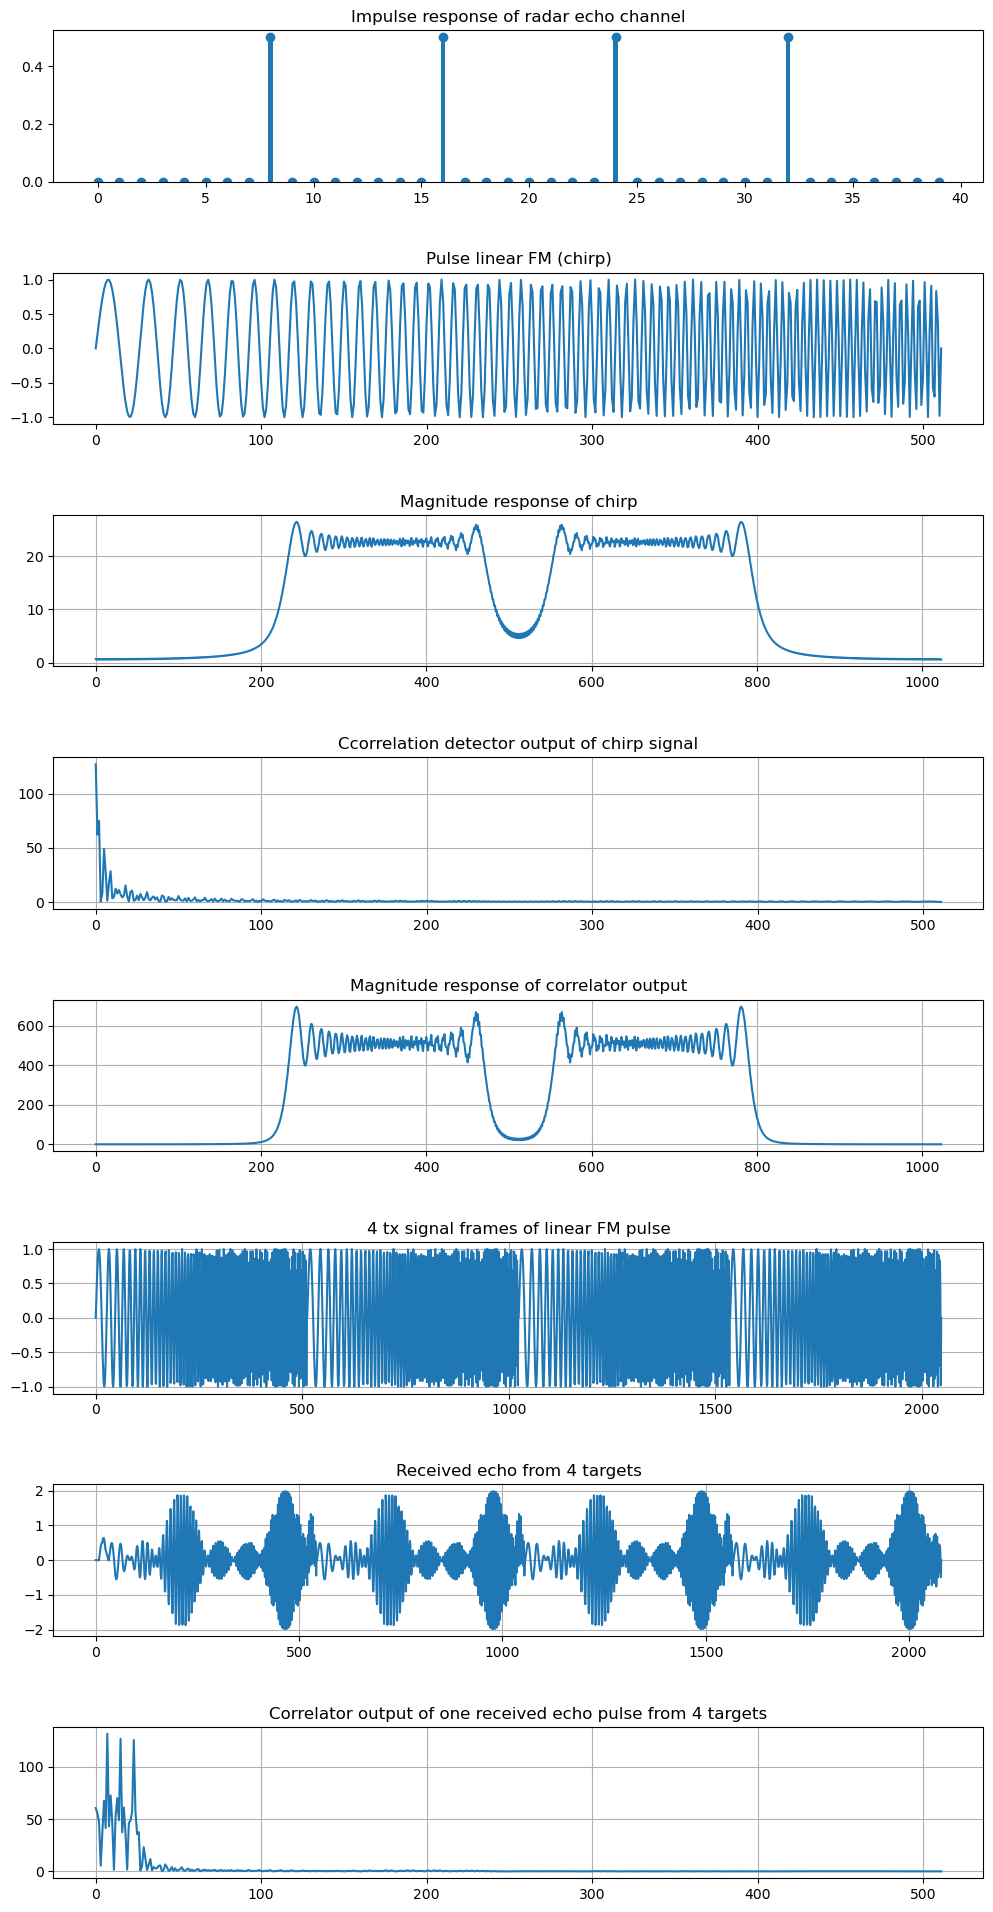

In [58]:
td_res = 512
num_fr = 4
fft_sz = td_res*2

# target reflection: dispersion model (impulse response)
num_targets = 4
tgt_spacing = int(td_res/64)    # # samples spacing between the targets
echo_delay = int(td_res/64)
tgt_disp_ir = np.zeros(int(echo_delay+num_targets*tgt_spacing))
tgt_disp_ir[echo_delay:int(echo_delay+num_targets*tgt_spacing):tgt_spacing] = 1/np.sqrt(num_targets)

fig,ax=plt.subplots(8)
fig.set_size_inches((12,24))
fig.subplots_adjust(hspace=.6)
ax_idx=0
ax[ax_idx].bar (range(len(tgt_disp_ir)),tgt_disp_ir, width=0.2)
ax[ax_idx].plot(range(len(tgt_disp_ir)),tgt_disp_ir, 'o')
ax[ax_idx].set_title('Impulse response of radar echo channel')
ax_idx=ax_idx+1

win = signal.windows.boxcar(td_res)

# generate the transmit signal
fc = 16
bw_exp = 4
t=np.linspace(0,1,td_res)
x=np.sin ( 2*pi*fc * (1 + bw_exp*t) *t )
#x=np.sin(32*pi*t)
X=fft.fft(x*win,fft_sz)

# Demo the demodulation by match filter
y=np.flipud(x)
Y=fft.fft(y,fft_sz)
Xh=X*Y
xh=np.real(fft.ifft(Xh,fft_sz)[td_res:])
# Pulse in time and frequency domains
ax[ax_idx].plot(x)
ax[ax_idx].set_title('Pulse linear FM (chirp)')
ax_idx=ax_idx+1
ax[ax_idx].plot(np.abs((fft.fftshift(X))))
ax[ax_idx].grid(True)
ax[ax_idx].set_title('Magnitude response of chirp')
ax_idx=ax_idx+1
# autocorrelation of pulse using FFT (samples and frequency)
ax[ax_idx].plot(np.abs(xh))
#ax[ax_idx].set_ylim([-30,90])
ax[ax_idx].grid(True)
ax[ax_idx].set_title('Ccorrelation detector output of chirp signal')
ax_idx=ax_idx+1

ax[ax_idx].plot(np.abs(fft.fftshift(Xh)))
ax[ax_idx].grid(True)
ax[ax_idx].set_title('Magnitude response of correlator output')
ax_idx=ax_idx+1

#td_grid=range(0,int(td_res*num_fr),64)

xs=np.empty((len(x)*num_fr))
for f in range(num_fr):
    start_sample = f*td_res
    xs[start_sample:start_sample+td_res] = x
# transmitted pulse train
ax[ax_idx].plot(xs)
ax[ax_idx].grid(True)
ax[ax_idx].set_title(f'%u tx signal frames of linear FM pulse' % (num_fr))
ax_idx=ax_idx+1

# simulate received echo signal
ys = np.convolve(xs,tgt_disp_ir,'full')
# Plot received signal after target reflections
ax[ax_idx].plot(ys[:len(xs)+tgt_spacing*num_fr])
ax[ax_idx].grid(True)
ax[ax_idx].set_title(f'Received echo from %u targets' % (num_targets))
ax_idx=ax_idx+1

# demodulate received pulses
demod_start_frame=2
xsh = np.zeros(int(td_res*(num_fr-demod_start_frame)))
Xsh = np.zeros(int(len(xsh)*2),dtype='complex')
for f in range(num_fr-demod_start_frame):
    start_sample = echo_delay + (f+demod_start_frame)*td_res
    Xsh = fft.fft(win*ys[start_sample:start_sample+td_res],fft_sz)
    Xsh = Xsh*Y
    xsh[f*td_res:(f+1)*td_res] = np.real(fft.ifft(Xsh)[td_res:])
# matched filter output for one pulse duration
ax[ax_idx].plot(np.abs(xsh[:td_res]))
#ax[ax_idx].set_ylim([-80,60])
#ax[ax_idx].set_xticks(td_grid);
ax[ax_idx].grid(True)
ax[ax_idx].set_title(f'Correlator output of one received echo pulse from %u targets' % (num_targets));
ax_idx=ax_idx+1